In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from highlight_text import ax_text
from pyfonts import set_default_font, load_bunny_font

In [2]:
companies = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2026/2026-01-27/companies.csv")

In [3]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141332 entries, 0 to 141331
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_id           141332 non-null  int64  
 1   company_name         141332 non-null  object 
 2   legal_nature         141332 non-null  object 
 3   owner_qualification  141332 non-null  object 
 4   capital_stock        141332 non-null  float64
 5   company_size         141332 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.5+ MB


In [4]:
companies.head(2)

,company_id,company_name,legal_nature,owner_qualification,capital_stock,company_size
0,41273639,MH MATERIAIS DE CONSTRUCAO LTDA,Limited Liability Business Company (LLC),Managing Partner / Partner-Administrator,1000000.0,small-enterprise
1,41274138,CLINICA ESTETICA CAXIAS DO SUL RS LTDA,Limited Liability Business Company (LLC),Managing Partner / Partner-Administrator,200000.0,micro-enterprise


In [5]:
# Define companies that are in the top 1% of capital stock
threshold = companies["capital_stock"].quantile(0.99)
companies["high_capital"] = companies["capital_stock"] >= threshold

In [6]:
# Create 2 new dfs based on filters
hc = companies[companies["high_capital"] == True]
nhc = companies[companies["high_capital"] == False]

In [7]:
# Function to group and aggregate dfs
def group_and_agg(df):    
    df_grouped = (
        df.groupby("legal_nature")
          .agg(
              total_capital=("capital_stock", "sum"),
              num_companies=("company_id", "count")
          )
          .reset_index()
    )
    return df_grouped

In [8]:
# Apply function and add new column
hc_grouped = group_and_agg(hc)
hc_grouped["category"] = "high capital"
nhc_grouped = group_and_agg(nhc)
nhc_grouped["category"] = "non-high capital"

In [9]:
# Concatenate dfs
df = pd.concat([hc_grouped, nhc_grouped]).sort_values("legal_nature", ignore_index=True)

In [10]:
color_mapping = {
    "non-high capital": "#009C3B",
    "high capital": "#FFDF00"   
}
colors = df["category"].map(color_mapping)

In [11]:
# Set custom font globally
font = load_bunny_font("Roboto Condensed")
set_default_font(font)

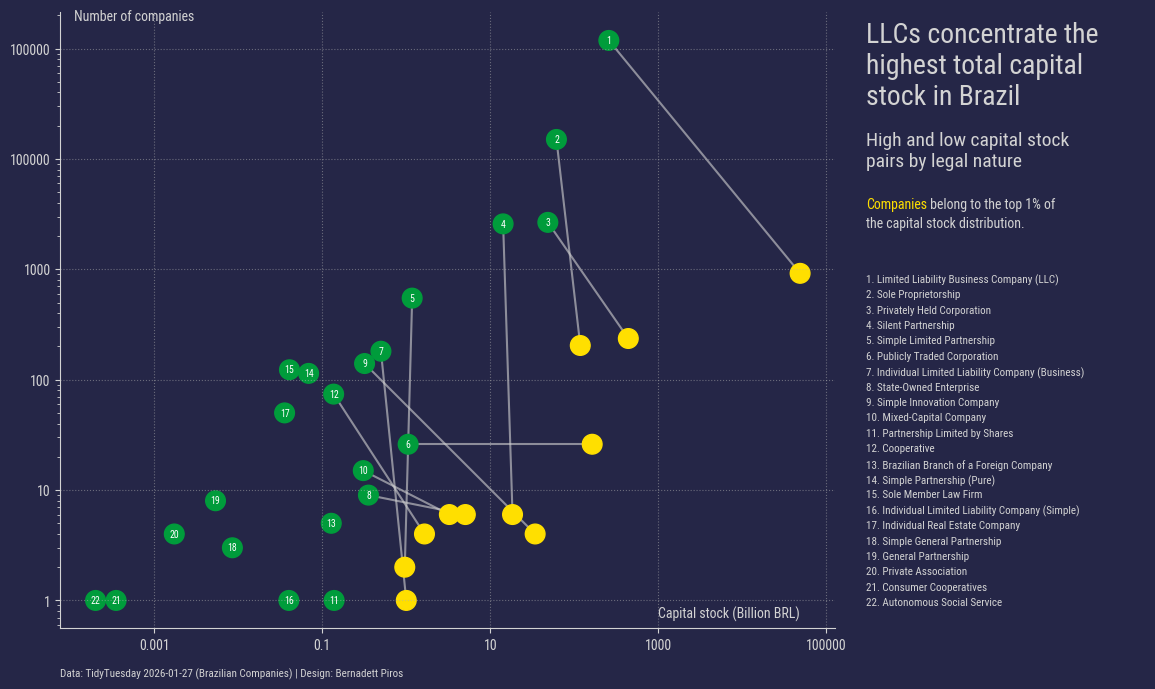

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# Loop through legal nature groups
for ln, sub in df.groupby("legal_nature"):
    # Empty lists to store x and y values for the pairs
    xv, yv = [], []

    # Loop through each row of the group 
    for i, row in sub.iterrows():
        # Append xv and yv for each row to the lists
        xv.append(row["total_capital"])
        yv.append(row["num_companies"])    
        # Plot lines
        ax.plot(xv, yv, color="lightgray", alpha=0.6, zorder=1)

# Plot scatter
ax.scatter(df["total_capital"],
           df["num_companies"],
           s=200,
           c=colors
          )

# Set log axis
ax.set_xscale("log")
ax.set_yscale("log")

# Subset for text annotations
subset=df[df["category"] == "non-high capital"].sort_values("total_capital", ascending=False).reset_index(drop=True)
# Loop through each row of subset and add i+1 number into the scatters
for i, row in subset.iterrows():
    t = i +1
    x_value = row["total_capital"]
    y_value = row["num_companies"]
    ax.text(
        x=x_value,
        y=y_value,
        s=t,
        ha="center",
        va="center",
        color="white",
        size=7,
    )

# Remove spines
ax.spines[["top", "right"]].set_visible(False)
# Color spines
ax.spines[["left", "bottom"]].set_color("lightgrey")

# Format axis ticks and labels
ax.tick_params(
    axis="both",
    which="both",    
    labelcolor="lightgrey",
    color="lightgrey",
)

# X axis label
ax.text(
    x=1e12,
    y=0.7,
    s="Capital stock (Billion BRL)",
    color="lightgrey",    
)

# Y axis label
ax.text(
    x=1e6/9,
    y=1e5+80000,
    s="Number of companies",
    color="lightgrey",    
)

# Set xticks
locationx = [1e6, 1e8, 1e10, 1e12, 1e14]
labelsx = ["0.001", "0.1", "10", "1000", "100000"]
ax.set_xticks(locationx, labels=labelsx)

# Set yticks
locationy = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
labelsy = ["1", "10", "100", "1000", "100000", "100000"]
ax.set_yticks(locationy, labels=labelsy)

# Add major grid lines
ax.grid(True, which="major", ls="dotted", alpha=0.5)

# Background color
ax.set_facecolor("#252647")
fig.set_facecolor("#252647")

# Create inset axes
child_ax = ax.inset_axes([1, 0, 0.4, 1])
child_ax.axis("off")

# Define lines for enumerated text
lines = subset["legal_nature"]
n = len(lines)
# Plot enumerated text
for i, ln in enumerate(lines, start=1):
    y = 0.05 + ((n - i) * 0.025)
    child_ax.text(0.1, y, f"{i}. {ln}", ha="left", va="top", fontsize=8, color="lightgrey")

# Title
child_ax.text(0.1, 0.85, "LLCs concentrate the\nhighest total capital\nstock in Brazil", size=20, color="lightgrey")

# Subtitles
child_ax.text(0.1, 0.75, "High and low capital stock\npairs by legal nature", size=14, color="lightgrey")
ax_text(0.1, 0.7, "<Companies> belong to the top 1% of\nthe capital stock distribution.", color="lightgrey", ax=child_ax,
       highlight_textprops=[
        {"color": "#FFDF00"}
    ])

# Add caption
fig.text(0.125, 0.05, "Data: TidyTuesday 2026-01-27 (Brazilian Companies) | Design: Bernadett Piros", color="lightgrey", size=8)

plt.show()

# Save figure
#fig.savefig("2026-01-27.png", bbox_inches="tight", pad_inches=0.2)